In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from Codes.Model_architectures_tran import simple_lstm, attention_lstm_model, non_recurrent_attention_model, transformer_model
from Codes.embedding_modules import doc2vec_dm, doc2vec_dbow, word2vec_cbow, word2vec_sg, fasttext_sg, fasttext_cbow
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf
import joblib

In [36]:
train = pd.read_csv('train_data_IFDP.csv')
test = pd.read_csv('test_data_IFDP.csv')

In [3]:
def run_end_to_end(train, test, model=None, save_path='trained_model_ifdp.h5'):
    
    # Use only the necessary columns
    train = pd.concat([train[["sig_gene_seq", "high_level_substr"]]], ignore_index=True)
    test = pd.concat([test[["sig_gene_seq", "high_level_substr"]]], ignore_index=True)
    
    # Get the order of substrate names based on their frequency in training data
    order = list(train["high_level_substr"].value_counts().index)

    # Label encoding for target labels
    le = LabelEncoder()
    le.fit(train["high_level_substr"].values)
    joblib.dump(le, 'label_encoder_ifdp.pkl')

    if model is not None:
        vec_size = model.wv.vectors.shape[1]

    # Prepare the sequences by replacing delimiters
    train_seqs = np.array([item.replace("|", ",").replace(",", " ") for item in train["sig_gene_seq"].values])
    test_seqs = np.array([item.replace("|", ",").replace(",", " ") for item in test["sig_gene_seq"].values])
    
    # Encode target labels
    y_train = le.transform(train["high_level_substr"].values)
    y_test = le.transform(test["high_level_substr"].values)
    
    # Compute class weights based on training data distribution
    weights = pd.Series(y_train).value_counts(normalize=True)
    class_weights = {i: 1 / w for i, w in weights.items()}

    # Define and train the model
    model_dl = transformer_model(len(order), False, model)
    model_dl.fit(train_seqs, y_train, validation_split=0.20, batch_size=1, epochs=1000, 
                 callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True), 
                 class_weight=class_weights, verbose=0)
    
    # Save the model
    model_dl.save(save_path)
    
    # Predict on the test data
    y_test_pred = model_dl.predict(test_seqs, batch_size=1, verbose=0)
    y_test_pred = y_test_pred.argmax(1)
    y_test_pred = le.inverse_transform(y_test_pred)  # Convert back to substrate names
    
    # Confusion matrix with substrate names in correct order
    cm = confusion_matrix(test["high_level_substr"], y_test_pred, labels=order, normalize='true')
    
    # Plot the confusion matrix
    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=order, yticklabels=order, 
                annot_kws={"fontsize":12, "weight":"bold"}, cmap="Blues")
    
    plt.title("Confusion Matrix on Substrate Names", fontsize=20, weight="bold")
    plt.xlabel("Predicted Label", fontsize=15, weight="bold")
    plt.ylabel("True Label", fontsize=15, weight="bold")
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    
    # Save the confusion matrix plot
    plt.savefig('Confusion_IFDP.png', format='png', bbox_inches='tight')
    
    # Plot the training and validation loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # Calculate accuracy metrics
    avg_acc = accuracy_score(test["high_level_substr"], y_test_pred)
    avg_class_acc = np.mean(np.diag(cm))  # Class-wise average accuracy from confusion matrix diagonal
    
    # Return the relevant results
    return avg_acc, avg_class_acc, model_dl, fig


In [57]:
def run_end_to_end(train, test, model=None, save_path='trained_model_ifdp.h5'):
    
    # Use only the necessary columns
    train = pd.concat([train[["sig_gene_seq", "high_level_substr"]]], ignore_index=True)
    test = pd.concat([test[["sig_gene_seq", "high_level_substr"]]], ignore_index=True)
    
    # Get the order of substrate names based on their frequency in training data
    order = list(train["high_level_substr"].value_counts().index)

    # Label encoding for target labels
    le = LabelEncoder()
    le.fit(train["high_level_substr"].values)
    joblib.dump(le, 'label_encoder_ifdp.pkl')

    if model is not None:
        vec_size = model.wv.vectors.shape[1]

    # Prepare the sequences by replacing delimiters
    train_seqs = np.array([item.replace("|", ",").replace(",", " ") for item in train["sig_gene_seq"].values])
    test_seqs = np.array([item.replace("|", ",").replace(",", " ") for item in test["sig_gene_seq"].values])
    
    # Encode target labels
    y_train = le.transform(train["high_level_substr"].values)
    y_test = le.transform(test["high_level_substr"].values)
    
    # Compute class weights based on training data distribution
    weights = pd.Series(y_train).value_counts(normalize=True)
    class_weights = {i: 1 / w for i, w in weights.items()}
    
        # Define a learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10,
        decay_rate=0.9,
        staircase=True)

    # Define the optimizer with the scheduler
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Define and train the model
    model_dl = transformer_model(len(order), False, model)
    history = model_dl.fit(train_seqs, y_train, validation_split=0.2, batch_size=1, epochs=2000, 
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True)], 
                 class_weight=class_weights, verbose=0)
    
    # Save the model
    model_dl.save(save_path)
    
    # Predict on the test data
    y_test_pred = model_dl.predict(test_seqs, batch_size=1, verbose=0)
    y_test_pred = y_test_pred.argmax(1)
    y_test_pred = le.inverse_transform(y_test_pred)  # Convert back to substrate names
    
    # Confusion matrix with substrate names in correct order
    cm = confusion_matrix(test["high_level_substr"], y_test_pred, labels=order, normalize='true')
    
    # Plot the confusion matrix
    fig_cm = plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=order, yticklabels=order, 
                annot_kws={"fontsize":12, "weight":"bold"}, cmap="Blues")
    plt.title("Confusion Matrix on Substrate Names", fontsize=20, weight="bold")
    plt.xlabel("Predicted Label", fontsize=15, weight="bold")
    plt.ylabel("True Label", fontsize=15, weight="bold")
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    
    # Save the confusion matrix plot
    plt.savefig('Confusion_IFDP.png', format='png', bbox_inches='tight')
    
    # Plot training and validation loss
    fig_loss = plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Over Epochs', fontsize=20, weight="bold")
    plt.xlabel('Epoch', fontsize=15, weight="bold")
    plt.ylabel('Loss', fontsize=15, weight="bold")
    plt.legend()
    plt.grid(True)
    
    # Save the training and validation loss plot
    plt.savefig('Training_Validation_Loss.png', format='png', bbox_inches='tight')
    
    # Calculate accuracy metrics
    avg_acc = accuracy_score(test["high_level_substr"], y_test_pred)
    avg_class_acc = np.mean(np.diag(cm))  # Class-wise average accuracy from confusion matrix diagonal
    
    # Return the relevant results
    return avg_acc, avg_class_acc, model_dl, fig_cm, fig_loss


In [10]:
import os
import gensim


In [6]:
############################
K = 5
known_unknown = False

# Define the base path for the models
base_path = "Embedding_Models"

# Use os.path.join to construct the file paths
model_sg_path = os.path.join(base_path, "word2vec_sg")

# Load the models
model_sg = gensim.models.word2vec.Word2Vec.load(model_sg_path)



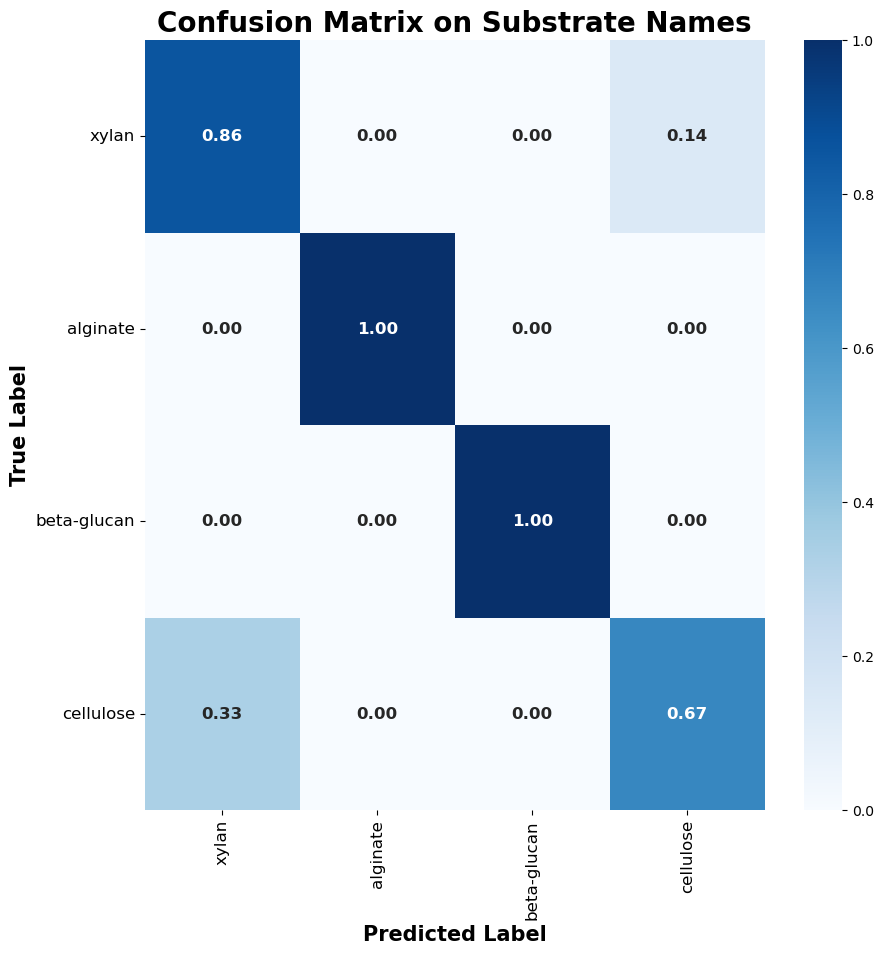

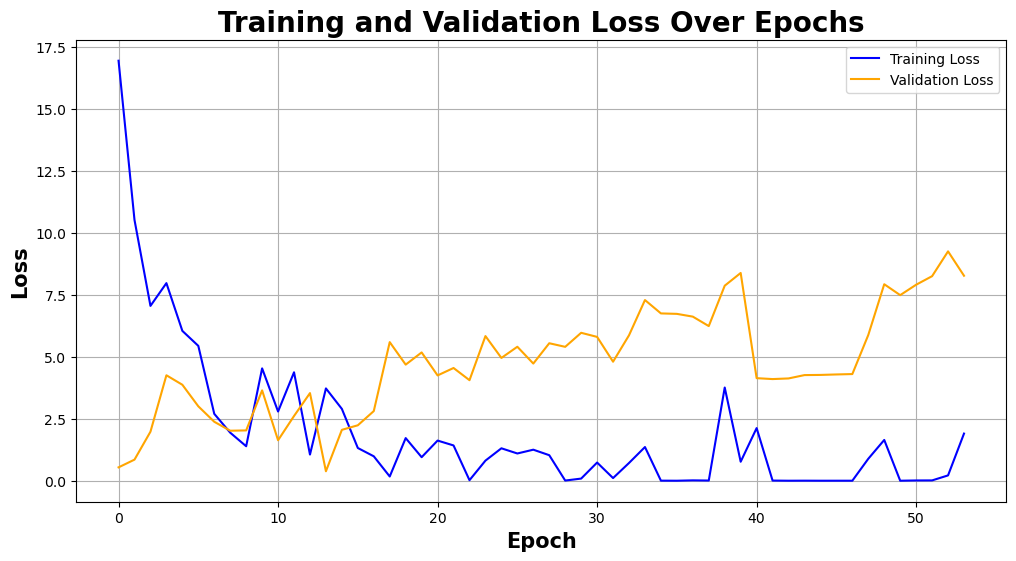

In [58]:
avg_acc, avg_class_acc, model_dl,fig_cm, fig_loss= run_end_to_end(train, test, model_sg, save_path='trained_model_ifdp.h5')        

In [59]:
avg_acc

0.8947368421052632